# Approximation of multiplication operators

In [1]:
%load_ext nb_mypy
%nb_mypy On
    
%matplotlib ipympl

Version 1.0.3


In [2]:
import matplotlib.pyplot as plt
import nlsa.fourier_s1 as f1
import nlsa.fourier_t2 as f2
import nlsa.function_algebra as fun
import numpy as np

from functools import partial
from ipywidgets import widgets, interactive, interact, IntSlider
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from multiprocess import Pool
from nlsa.function_algebra import compose
from nlsa.matrix_algebra import pure_state
from nptyping import Complex, Double, Int, NDArray, Shape
from scipy.linalg import eig, norm
from typing import Callable, Tuple, TypeVar

In [3]:
I = int
I2 = Tuple[int, int]
R = float
R2 = Tuple[float, float]

X = NDArray[Shape["*"], Double]
X2 = NDArray[Shape["*, 2"], Double]
Y = NDArray[Shape["*"], Double]
F = Callable[[X], Y]
F2 = Callable[[X2], Y]

N = TypeVar("N")
V = TypeVar("V", NDArray[Shape["N"], Double], NDArray[Shape["N"], Complex])
M = TypeVar("M", NDArray[Shape["N"], Double], NDArray[Shape["N, N"], Complex])

In [4]:
def eig_sorted(a: M) -> Tuple[V, M]:
    w, v = eig(a)
    idx = w.real.argsort()
    w = w[idx]
    v = v[:, idx]
    return w, v

## Von Mises density on the circle

In [5]:
def vm(kappa: R) -> F:
    """Von Mises density centered at pi."""
    f: F = f1.von_mises(kappa, loc=np.pi)
    return f

def vm_fourier(kappa: R, l: I) -> V:
    """Fourier coefficients of von Mises density centered at pi."""
    vm_hat = f1.von_mises_fourier(kappa, loc=np.pi)
    f_hat: V = vm_hat(f1.dual_group(l))
    return f_hat

In [6]:
def feature_map(epsilon: R, l: I) -> Callable[[X2], V]:
    """Feature map based on von Mises density."""
    kappa = epsilon ** -2
    xi_0 = f1.von_mises_feature_map(kappa, l)
    z = np.linalg.norm(xi_0(np.array([0])))
    
    def xi(x: X2) -> V:
        return xi_0(x) / z
    return xi

def qm_recon(a: M, xi: Callable[[X], V]) -> Callable[[X], Y]:
    def f(x: X):
        omega = pure_state(xi(x))
        return omega(a)
    return f

<cell>13: error: Argument 1 to "pure_state" has incompatible type "ndarray[Any, dtype[complexfloating[Any, Any]]]"; expected "ndarray[Any, dtype[floating[Any]]]"
<cell>14: error: Argument 1 has incompatible type "ndarray[Any, dtype[complexfloating[Any, Any]]]"; expected "ndarray[Any, dtype[floating[Any]]]"


In [12]:
kappa = 10
l = 16

mult_op = f1.mult_op_fourier(l)
synth = partial(fun.synthesis, f1.fourier_basis(l))
phi = f1.fourier_basis(l)

f = vm(kappa)
f_hat = vm_fourier(kappa, 2 * l)
f_proj = synth(vm_fourier(kappa, l))
f_mult = mult_op(f_hat)

y, c = eig_sorted(f_mult)


In [10]:
n_plt_x = 256
n_plt_eig = y.size - 1
i_fig = 1

x = np.linspace(0, 2*np.pi, n_plt_x)
x1 = x / np.pi
fx = f(x)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax2 = ax.twinx()
j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

@interact(j=j_slider) 
def plotfunc(j):
    u = synth(c[:, j])
    lam = y[j].real
    ux = u(x)
    if norm(ux.real) > norm(ux.imag):
        ux_plt = ux.real
    else:
        ux_plt = ux.imag
    if np.max(ux_plt) < np.max(-ux_plt):
        ux_plt = -1 * ux_plt
    ax.cla()
    ax2.cla()
    ax2._get_lines.prop_cycler = ax._get_lines.prop_cycler
    ax.plot(x1, ux_plt, label="$u_j$")
    ax2.plot(x1, fx, label="$f$")
    ax2.axhline(y=lam, color='g', label="$\lambda_j$")
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    ax2.set_ylabel("$f$, $\lambda_j$")
    ax2.set_xlim(0, 2)
    ax.grid()
    ax.set_xlabel("$\\theta_1/\\pi$")
    ax.set_ylabel("$u_j$")
    ax.set_xlim(0, 2)
    ax.set_title(f"Eigenfunction $u_{{{j}}}$, $\lambda_{{{j}}} = {lam:.3g}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=6), Output()), _dom_cla…

In [17]:
epsilon = 0.05

f_qm = qm_recon(f_mult, feature_map(epsilon, l)) 

<cell>9: error: Argument 1 has incompatible type "ndarray[Any, dtype[floating[Any]]]"; expected "X"


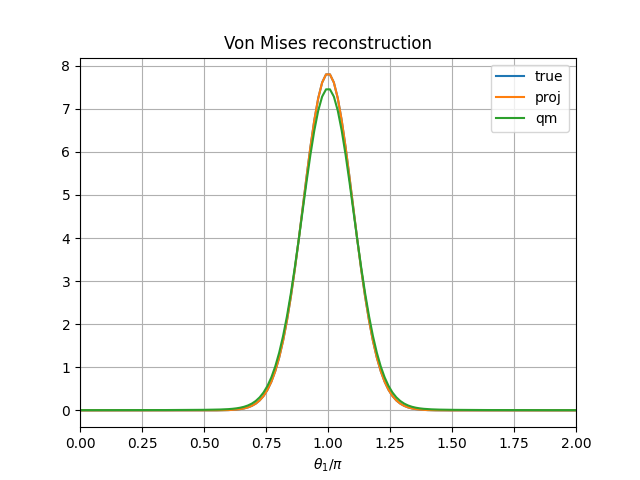

In [18]:
n_plt_x = 128
n_plt_eig = y.size - 1
i_fig = 2

x = np.linspace(0, 2*np.pi, n_plt_x)
x1 = x / np.pi
fx = f(x)
f_qmx = np.real(f_qm(x))
f_projx = np.real(f_proj(x))

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
#j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

#@interact(j=j_slider) 
def plotfunc():
    ax.cla()
    ax.plot(x1, fx, label="true")
    ax.plot(x1, f_projx, label="proj")
    ax.plot(x1, f_qmx, label="qm")
    ax.legend()
    ax.set_xlim(0, 2)
    ax.grid()
    ax.set_xlabel("$\\theta_1/\\pi$")
    ax.set_title(f"Von Mises reconstruction")
    plt.show()
    
plotfunc()

## Von Mises density on the 2-torus

In [14]:
def vm2(kappa: R2) -> F2:
    """Von Mises density centered at (pi, pi)."""
    f: F2 = f2.von_mises(kappa, loc=(np.pi, np.pi))
    return f

def vm2_fourier(kappa: R2, l: I2) -> V:
    """Fourier coefficients of von Mises density centered at (pi, pi)."""
    vm_hat = f2.von_mises_fourier(kappa, loc=(np.pi, np.pi))
    f_hat: V = vm_hat(f2.dual_group(l))
    return f_hat

<cell>9: error: Incompatible types in assignment (expression has type "ndarray[Any, dtype[complexfloating[Any, Any]]]", variable has type "ndarray[Any, dtype[floating[Any]]]")


In [28]:
kappa = (10, 10)
l = (32, 32)

mult_op = f2.mult_op_fourier(l)
synth = partial(fun.synthesis, f2.fourier_basis(l))
phi = f2.fourier_basis(l)

f = vm2(kappa)
f_hat = vm2_fourier(kappa, (2 * l[0], 2 * l[1]))
f_mult = mult_op(f_hat)

y, c = eig_sorted(f_mult)

<cell>10: error: Argument 1 has incompatible type "ndarray[Any, dtype[floating[Any]]]"; expected "ndarray[Any, dtype[complexfloating[Any, Any]]]"


In [29]:
n_plt_x = 256
n_plt_eig = y.size - 1
i_fig = 11

theta = np.linspace(0, 2*np.pi, n_plt_x)
x1, x2 = np.meshgrid(theta, theta)
x = np.concatenate((x1[:-1, :-1, np.newaxis], x2[:-1, :-1, np.newaxis]), 
                   axis=2)
x1 = x1 / np.pi
x2 = x2 / np.pi

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad="2%")
j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_(j):
    u = synth(c[:, j])
    lam = y[j].real
    ux = u(x)
    if norm(ux.real) > norm(ux.imag):
        ux_plt = ux.real
    else:
        ux_plt = ux.imag
    if np.max(ux_plt) < np.max(-ux_plt):
        ux_plt = -1 * ux_plt
    ax.cla()
    cax.cla()
    im = ax.pcolormesh(x1, x2, ux_plt)
    cb = fig.colorbar(im, cax=cax)
    ax.set_xlabel('$\\theta_1/\\pi$')
    ax.set_ylabel('$\\theta_2/\\pi$')
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    cax.set_ylabel("$u_j$")
    ax.set_title(f"Eigenfunction $u_{{{j}}}$, $\lambda_{{{j}}} = {lam:.3g}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=4224), Output()), _dom_…